# The Imitation Gap for Learning from Experts with Privileged Information
---

In this notebook, we aim to show the failure of naive imitation learning (behaviour cloning) from experts who have access to more information than the learner. We will focus on the example used in [this paper](https://arxiv.org/pdf/2007.12173), called 2D-Lighthouse. The environment is an $N \times N$ grid-world task, where the goal location is a randomly chosen corner of the grid, and the agent can only see a local region with a radius of $i$. See below as an example:

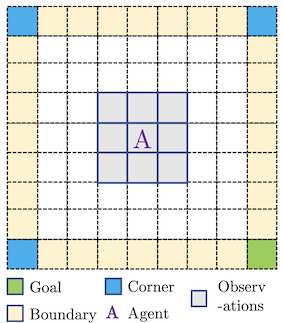

Our aim is to train the agent to imitate an expert with a view radius of $j \geq i$.

We first implement the 2D-Lighthouse using the Gym library. Our implementation takes the grid size and the view radius as input.

In [1]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import numpy as np
import gym
from gym import spaces
import random

# Define the 2D-Lighthouse environment
class LighthouseEnv(gym.Env):
    def __init__(self, grid_size: int, view_radius: int):
        super(LighthouseEnv, self).__init__()
        self.grid_size = grid_size
        self.view_radius = view_radius

        # Define action and observation spaces
        self.action_space = spaces.Discrete(4)

        # Establish a random goal position in one of the corners
        self.goal_pos = [random.choice([0, grid_size - 1]),
                         random.choice([0, grid_size - 1])]
        self.agent_pos = [grid_size // 2, grid_size // 2]

    def reset(self):
        self.agent_pos = [self.grid_size // 2, self.grid_size // 2]
        self.goal_pos = [random.choice([0, self.grid_size - 1]),
                         random.choice([0, self.grid_size - 1])]
        return self._get_obs(self.view_radius)

    def step(self, action: int):
        if action == 0:   # Up
            self.agent_pos[0] = max(0, self.agent_pos[0] - 1)
        elif action == 1: # Right
            self.agent_pos[1] = min(self.grid_size - 1, self.agent_pos[1] + 1)
        elif action == 2: # Down
            self.agent_pos[0] = min(self.grid_size - 1, self.agent_pos[0] + 1)
        elif action == 3: # Left
            self.agent_pos[1] = max(0, self.agent_pos[1] - 1)

        done = (self.agent_pos == self.goal_pos)
        reward = 1 if done else 0
        return self._get_obs(self.view_radius), reward, done, {}

    def _get_obs(self, view_radius: int):
        # Observation is a local view around the agent
        obs = np.zeros((2 * view_radius + 1, 2 * view_radius + 1))
        for i in range(-view_radius, view_radius + 1):

            for j in range(-view_radius, view_radius + 1):
                ni, nj = self.agent_pos[0] + i, self.agent_pos[1] + j
                if 0 <= ni < self.grid_size and 0 <= nj < self.grid_size:
                    if [ni, nj] == self.goal_pos:
                        obs[i + view_radius, j + view_radius] = 1
                else:
                    obs[i + view_radius, j + view_radius] = -1
        return (obs, self.agent_pos)

We now implement an optimal agent with a view radius of $j$. As the agent always start at the center, the optimal behaviour is to pick a corner, move towards it, and as soon as the agent observes that the corner does not contain the goal, move to the next corner until the agent reaches the goal. In the following, we implement this behaviour.

In [2]:
# Define the optimal agent
class Agent:
    def act(self, obs, pos):
        pass

class OptimalAgent(Agent):
    def __init__(self, grid_size: int, view_radius: int):
        self.corners_visible = [[view_radius, view_radius],
                        [view_radius, grid_size-1 - view_radius],
                        [grid_size-1 - view_radius, grid_size-1 - view_radius],
                        [grid_size-1 - view_radius, view_radius]]
        self.corners = [[0, 0], [0, grid_size-1], [grid_size-1, grid_size-1], [grid_size-1, 0]]
        self.current_target = 0
        self.view_radius = view_radius

    def _go_to_target(self, pos, target):
        if pos[0] < target[0]:
            return 2 # Down
        elif pos[0] > target[0]:
            return 0 # Up
        elif pos[1] < target[1]:
            return 1 # Right
        elif pos[1] > target[1]:
            return 3 # Left
        else:
            return None

    def _find_one_position(self, obs, pos):
          ones_pos = np.where(obs == 1)
          agent_rel_pos = [obs.shape[0] // 2, obs.shape[1] // 2]
          ones_rel_pos = [ones_pos[0][0] - agent_rel_pos[0],
                          ones_pos[1][0] - agent_rel_pos[1]]

          return [pos[0] + ones_rel_pos[0], pos[1] + ones_rel_pos[1]]

    def act(self, obs, pos):
        if 1 in obs:
            one_pos = self._find_one_position(obs, pos)
            target = self.corners[self.current_target]
            if one_pos != target:
                self.current_target = (self.current_target + 1) % 4
                return self.act(obs, pos)
            else:
                return self._go_to_target(pos, target)
        else:
            target = self.corners_visible[self.current_target]
            action = self._go_to_target(pos, target)
            if action is None:
                self.current_target = (self.current_target + 1) % 4
                return self.act(obs, pos)
            else:
                return action

Moreover, we have the following function to generate the expert demonstration data to train a behaviour cloning agent. Note that the learning agent's view radius and the expert's view radius can be different.

In [3]:
# Generate demonstrations
def generate_demonstrations(grid_size: int,
                            expert_view_radius: int,
                            agent_view_radius: int,
                            num_episodes: int):

    env = LighthouseEnv(grid_size, agent_view_radius)
    expert = OptimalAgent(grid_size, expert_view_radius)
    demonstrations = []

    for i in range(num_episodes):
        obs = env.reset()
        done = False
        while not done:
            action = expert.act(*env._get_obs(expert_view_radius))
            if action is not None:
                next_obs, _, done, _ = env.step(action)
                demonstrations.append((obs, action))
                obs = next_obs
    return demonstrations

Finally, we implement a simple behaviour cloning algorithm using logistic regression and test the learned agent for different values of $i$ and $j$.

In [4]:
# Behaviour Cloning
from sklearn.linear_model import LogisticRegression

def train_BC(demonstrations):
    X = [np.concatenate([obs[0].flatten(), obs[1]]) for obs, _ in demonstrations]
    y = [action for _, action in demonstrations]

    model = LogisticRegression(max_iter=1000)
    model.fit(X, y)

    # Similar interface to expert
    agent = Agent()
    agent.act = lambda obs, pos: model.predict([np.concatenate([obs.flatten(), pos])])[0]
    return agent

def test_agent(grid_size, view_radius, agent, num_episodes, max_steps):
    env = LighthouseEnv(grid_size, view_radius)
    length_to_complete = []

    for i in range(num_episodes):
        obs = env.reset()
        done = False
        steps = 0
        while not done and steps < max_steps:
            action = agent.act(*obs)
            obs, _, done, _ = env.step(action)
            steps += 1
        length_to_complete.append(steps)
    return np.mean(length_to_complete), np.std(length_to_complete)


In [5]:
grid_size = 2 * 10 + 1
agent_view_radius = [i+1 for i in range(5)]
expert_extra_radius = [i for i in range(5)]

imitation_gap_matrix = np.zeros((len(agent_view_radius),
                                 len(expert_extra_radius)))
for ii, i in enumerate(agent_view_radius):
  for kk, k in enumerate(expert_extra_radius):
      j = i + k
      demonstrations = generate_demonstrations(grid_size, expert_view_radius=j, agent_view_radius=i, num_episodes=200)
      expert = OptimalAgent(grid_size, j)
      expert_mean, expert_std = test_agent(grid_size, j, expert, num_episodes=100, max_steps=100)

      agent = train_BC(demonstrations)
      agent_mean, agent_std = test_agent(grid_size, i, agent, num_episodes=100, max_steps=100)
      imitation_gap = agent_mean - expert_mean
      imitation_gap_matrix[ii, kk] = imitation_gap

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


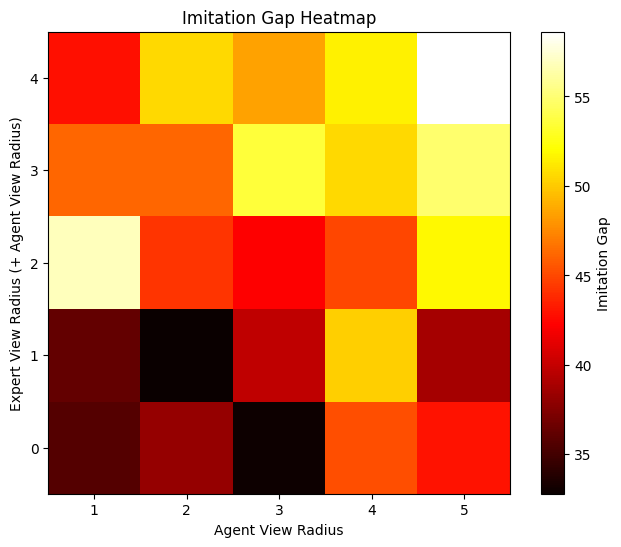

In [6]:
# Heat map of imitation gap for different values of i and j
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(imitation_gap_matrix, cmap='hot', interpolation='nearest', origin='lower')
plt.colorbar(label='Imitation Gap')
plt.xticks(ticks=range(len(agent_view_radius)), labels=agent_view_radius)
plt.yticks(ticks=range(len(expert_extra_radius)), labels=expert_extra_radius)
plt.xlabel('Agent View Radius')
plt.ylabel('Expert View Radius (+ Agent View Radius)')
plt.title('Imitation Gap Heatmap')
plt.show()

The overall pattern of the heatmap shows that the imitation gap increases as the difference between the expert view radius and the agent view radius gets larger.